In [4]:
# Python Lib
import os

# Extended Libs
import numpy as np
import pandas as pd
import json

# Plotting Libs
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.spatial.distance import cdist


# Choose file:
import tkinter as tk

# Own functions:
from functions import sar_data_processing as sar_dp
from functions import norsat_data_processing as norsat_dp
from functions import ais_data_processing as ais_dp

In [2]:
def plot_lat_lon_map(dfs_dict : dict , date) -> None:
        """
        Plots latitude and longitude from multiple DataFrames on the same map.

        Parameters:
        dfs_dict (dict): A dictionary where keys are labels (e.g., date_keys) and values are DataFrames containing 'Latitude' and 'Longitude'.

        """
        # Initialize the map
        plt.figure(figsize=(10, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())

        # Determine the overall extent based on all dataframes
        all_lats = []
        all_lons = []
        for df in dfs_dict.values():
            all_lats.extend(df['latitude'])
            all_lons.extend(df['longitude'])

        # Set the extent (slightly extended) for the map
        ax.set_extent([min(all_lons)-5, max(all_lons)+5, min(all_lats)-5, max(all_lats)+5])

        # Add features like coastlines and borders
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        # Plot each DataFrame's points with different markers or colors
        for label, df in dfs_dict.items():
            ax.scatter(df['longitude'], df['latitude'], label=label, s=10, transform=ccrs.PlateCarree())

        # Add gridlines and labels
        gl = ax.gridlines(draw_labels = True, crs = ccrs.PlateCarree(), linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 12, 'color': 'black'}
        gl.ylabel_style = {'size': 12, 'color': 'black'}

        # Add a legend to differentiate between different DataFrames
        plt.legend(title = "DataFrames", loc = 'upper right')

        # Add a title
        plt.title(f'Mapping of {date}')

        # Show the plot
        plt.show()

def match_ais_to_sar(sar_data, ais_data, time_threshold_seconds = 10, dist_threshold = 0.01, size_threshold = 100):
    matched_data_pos = []
    matched_data = []

    for idx, sar_row in sar_data.iterrows():
        # Compute the absolute time difference in seconds
        time_diff = np.abs(ais_data['TimeStamp'] - sar_row['Start']).astype('timedelta64[s]').astype('int64')
        
        # Filter AIS data by time proximity
        ais_filtered = ais_data[time_diff <= time_threshold_seconds]
        
        if not ais_filtered.empty:
            # Convert coordinates to numpy arrays with float64 dtype
            sar_coords = np.array([sar_row['latitude'], sar_row['longitude']], dtype=np.float64).reshape(1, -1)
            ais_coords = np.array(ais_filtered[['latitude', 'longitude']], dtype=np.float64)
            
            # Calculate spatial proximity using cdist
            distances = cdist(sar_coords, ais_coords)
            
            # Find the closest AIS entry within the distance threshold
            min_distance_idx = np.argmin(distances)
            min_distance = distances[0, min_distance_idx]
            
            if min_distance < dist_threshold:
                closest_ais_row = ais_filtered.iloc[min_distance_idx]
                matched_row = {**sar_row.to_dict(), **closest_ais_row.to_dict()}
                matched_data_pos.append(matched_row)

                # Check if the length and width match closely enough
                length_diff = abs(sar_row['width'] - closest_ais_row['width']) / sar_row['width']
                width_diff = abs(sar_row['height'] - closest_ais_row['length']) / sar_row['height']
                
                if length_diff <= size_threshold and width_diff <= size_threshold:
                    matched_row = {**sar_row.to_dict(), **closest_ais_row.to_dict()}
                    matched_data.append(matched_row)
    
    processed = [pd.DataFrame(matched_data), pd.DataFrame(matched_data_pos)]
    return processed

#
def visualize_on_map(matched_data):
    # Create a map centered around the average latitude and longitude
    map_center = [matched_data['latitude'].mean(), matched_data['longitude'].mean()]
    m = folium.Map(location=map_center, zoom_start=6)

    # Add SAR detection markers
    for idx, row in matched_data.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"SAR Detection: {row['Object_ID']}",
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(m)

    # Add AIS markers
    for idx, row in matched_data.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"MMSI number: {row['mmsi']}",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(m)
    
    # Display the map
    return m


### Load data
AIS, SAR, & Norsat. 

For 3 days
- 02-11-2022, AIS & SAR
- 03-11-2022, AIS, SAR & Norsat
- 05-11-2022, AIS & SAR

In [3]:
### LOAD data ###

## AIS data ##
df_ais_0211 = pd.read_csv(filepath_or_buffer ="C:\\Users\\abelt\\OneDrive\\Desktop\\Kandidat\\ais\\ais_110215.csv")
df_ais_0311 = pd.read_csv(filepath_or_buffer ="C:\\Users\\abelt\\OneDrive\\Desktop\\Kandidat\\ais\\ais_110315.csv")
df_ais_0511 = pd.read_csv(filepath_or_buffer ="C:\\Users\\abelt\\OneDrive\\Desktop\\Kandidat\\ais\\ais_1105.csv")
# Compile into a dict #
dfs_ais = {'02-11-2022': df_ais_0211, '03-11-2022': df_ais_0311, '05-11-2022' : df_ais_0511}
# Format time value dtype into datetime dtype #
for df_ais in dfs_ais.values():
    df_ais.rename(columns = {'bs_ts':'time', 'lat':'latitude', 'lon':'longitude'}, inplace = True)
    df_ais['source'] = 'ais'
    df_ais["TimeStamp"] = pd.to_datetime(df_ais['time'])

## SAR data ##
df_sar_0211 = pd.read_json(path_or_buf = "C:\\Users\\abelt\\OneDrive\\Desktop\\Kandidat\\sar\\Sentinel_1_detection_20221102T1519.json", orient='index')
df_sar_0311 = pd.read_json(path_or_buf = "C:\\Users\\abelt\\OneDrive\\Desktop\\Kandidat\\sar\\Sentinel_1_detection_20221103T154515.json", orient='index')
df_sar_0511 = pd.read_json(path_or_buf = "C:\\Users\\abelt\\OneDrive\\Desktop\\Kandidat\\sar\\Sentinel_1_detection_20221105T162459.json", orient='index')
# Compile into a dict #
dfs_sar = {'02-11-2022': df_sar_0211, '03-11-2022': df_sar_0311, '05-11-2022' : df_sar_0511}
# Format time value dtype into datetime dtype #
for df_sar in dfs_sar.values():
    df_sar['source'] = 'sar'
    df_sar['Start'] = pd.to_datetime(df_sar['Start'])
    df_sar['End'] = pd.to_datetime(df_sar['End'])

## Norsat data ##
df_norsat_0211 = pd.read_json(path_or_buf = "C:\\Users\\abelt\\OneDrive\\Desktop\\Kandidat\\norsat\\Norsat3-N1-JSON-Message-DK-2022-11-02T151459Z.json")
df_norsat_0311 = pd.read_json(path_or_buf = "C:\\Users\\abelt\\OneDrive\\Desktop\\Kandidat\\norsat\\Norsat3-N1-JSON-Message-DK-2022-11-03T152759Z.json")
df_norsat_0511 = pd.read_json(path_or_buf = "C:\\Users\\abelt\\OneDrive\\Desktop\\Kandidat\\norsat\\Norsat3-N1-JSON-Message-DK-2022-11-05T155259Z.json")
# Compile into a dict #
dfs_norsat = {'02-11-2022': df_norsat_0211, '03-11-2022': df_norsat_0311, '05-11-2022' : df_norsat_0511}
# Extracting lat, lon for each ship detected #
for _, df_norsat in dfs_norsat.items():
    df_norsat['source'] = 'norsat'
    df_norsat = norsat_dp.norsat_formatting(df_norsat)

### Display dict keys and column names in dataframes ###
print('AIS:\n', dfs_ais.keys(), '\n', dfs_ais['02-11-2022'].columns)
print('SAR:\n', dfs_norsat.keys(), '\n', dfs_sar['02-11-2022'].columns)
print('Norsat:\n', dfs_sar.keys(), '\n',dfs_norsat['02-11-2022'].columns)

AIS:
 dict_keys(['02-11-2022', '03-11-2022', '05-11-2022']) 
 Index(['time', 'callsign', 'cog', 'destination', 'draught', 'eta', 'imo',
       'latitude', 'length', 'longitude', 'mmsi', 'nav_status', 'name', 'sog',
       'shiptype', 'width', 'source', 'TimeStamp'],
      dtype='object')
SAR:
 dict_keys(['02-11-2022', '03-11-2022', '05-11-2022']) 
 Index(['ProductType', 'Polarization', 'Swath', 'Start', 'End', 'Name',
       'Satellite', 'Shape', 'Objects', 'source'],
      dtype='object')
Norsat:
 dict_keys(['02-11-2022', '03-11-2022', '05-11-2022']) 
 Index(['TimeStamp', 'CollectionInformation', 'NRDEmitterPosition',
       'NumberCandidates', 'CandidateList', 'source', 'latitude', 'longitude'],
      dtype='object')


In [4]:
date_key = '03-11-2022'
delta_time = pd.Timedelta(minutes = 5)


# Expanding dfs_sar
expanded_sar_df = sar_dp.expand_objects_for_date(dfs_sar = dfs_sar, date_key = date_key)

# Filter data between two dates
filtered_ais_df = dfs_ais[date_key].loc[(dfs_ais[date_key]['TimeStamp'] >= (dfs_sar[date_key]['Start'][0] - delta_time))
                     & (dfs_ais[date_key]['TimeStamp'] <=  (dfs_sar[date_key]['Start'][0] + delta_time))]

#filtered_sar_df = expanded_sar_df.loc[(expanded_sar_df['Start'] >= (dfs_sar[date]['Start'][1]))
#                     & (expanded_sar_df['Start'] <=  (dfs_sar[date]['Start'][1]))]
filtered_sar_df = expanded_sar_df.loc[expanded_sar_df['class'] != 3]

filtered_norsat_df = dfs_norsat[date_key]

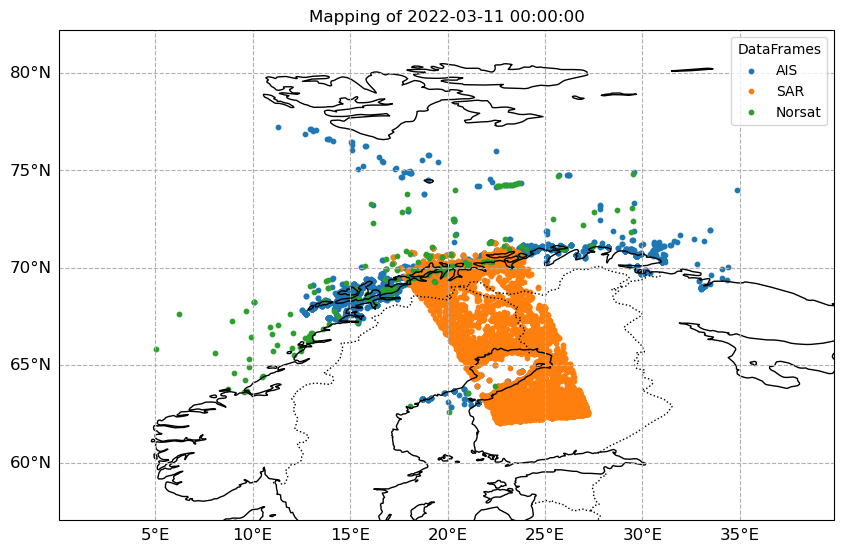

In [5]:
filter_dfs = {'AIS' : filtered_ais_df, 'SAR' : filtered_sar_df, 'Norsat' : filtered_norsat_df}
plot_lat_lon_map(dfs_dict = filter_dfs, date = pd.to_datetime(date_key))
#norsat_dp.plot_lat_lon_map(dfs_norsat)
expanded_df = sar_dp.expand_objects_for_date(dfs_sar, date_key)

In [6]:
# Converta values to floats, ints and datetime
# Convert to datetime if necessary
expanded_sar_df['Start'] = pd.to_datetime(expanded_sar_df['Start'])
filter_dfs['AIS']['TimeStamp'] = pd.to_datetime(filter_dfs['AIS']['TimeStamp'])

# Convert latitude and longitude to float if necessary
expanded_sar_df.loc[:, 'latitude'] = pd.to_numeric(expanded_sar_df['latitude'], errors='coerce')
expanded_sar_df.loc[:, 'longitude'] = pd.to_numeric(expanded_sar_df['longitude'], errors='coerce')
filter_dfs['AIS'].loc[:, 'latitude'] = pd.to_numeric(filter_dfs['AIS']['latitude'], errors='coerce')
filter_dfs['AIS'].loc[:, 'longitude'] = pd.to_numeric(filter_dfs['AIS']['longitude'], errors='coerce')


# Drop rows with NaN values in latitude or longitude after conversion
expanded_sar_df = expanded_sar_df.dropna(subset=['latitude', 'longitude'])
filter_dfs['AIS'] = filter_dfs['AIS'].dropna(subset=['latitude', 'longitude'])

C:\Users\abelt\AppData\Local\Temp\ipykernel_23396\3138391539.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_dfs['AIS']['TimeStamp'] = pd.to_datetime(filter_dfs['AIS']['TimeStamp'])


In [7]:
# Check if there are any non-numeric entries in latitude and longitude
#print("Checking SAR data for non-numeric latitude/longitude:")
#non_numeric_sar = expanded_sar_df[~expanded_sar_df[['latitude', 'longitude']].applymap(np.isreal).all(1)]
#print(non_numeric_sar)

#print("Checking AIS data for non-numeric latitude/longitude:")
#non_numeric_ais = filter_dfs['AIS'][~filter_dfs['AIS'][['latitude', 'longitude']].applymap(np.isreal).all(1)]
#print(non_numeric_ais)

# Drop rows with non-numeric latitude/longitude
#expanded_sar_df = expanded_sar_df[expanded_sar_df[['latitude', 'longitude']].applymap(np.isreal).all(1)]
#filter_dfs['AIS'] = filter_dfs['AIS'][filter_dfs['AIS'][['latitude', 'longitude']].applymap(np.isreal).all(1)]

In [8]:
# matching AIS and SAR:
matched_sar_ais = match_ais_to_sar(expanded_sar_df, filter_dfs['AIS'])

# Plotting:
m = visualize_on_map(matched_sar_ais[0])
m.save('matched_sar_ais_map.html')  # Save to an HTML file if needed
m